# LGT1 Unit07 Day29 - Pre-Class Assignment:  ML for the Inverse Problem in the Pseudo-PDF Method for LQCD
### <p style="text-align: right;"> &#9989; Put your name here.</p>


## Goals of this assignment

The goals of this assignment are:

* Learn the definition of an inverse problem
* Learn how psuedo-data can be used to train models to solve the inverse problem
* Learn the basic definition of a parton distribution function (PDF)
* Learn how machine learning can be applied to solve the inverse problem in the psuedo-PDF method for calculating PDFs from lattice QCD
* Explore the generation of psuedo-data for this problem (will use them for in-class assignement)

## Assignment instructions

Please complete assignment before noon Dec. 6th.

# Part 1: ML for the Inverse Problem in the Pseudo-PDF Method for LQCD
Watch the lecture video below

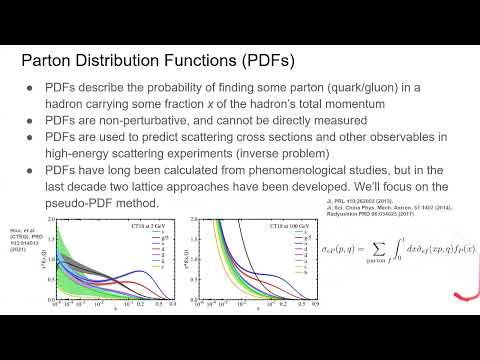

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("4_YXdABF2iI",width=640,height=340)
# Direct link on YourTube: https://www.youtube.com/watch?v=4_YXdABF2iI

# Part 2: Generate one sample of psuedo-data
The pre-class task is to generate just one sample of the pseudo-data and explore what the input and output will look like.
I will generate the samples that will be used for training the ML model for the in class assignment so that everyone has the same data.
Follow the code to generate and plot and example of the input data and output PDF.
Fill in any spots that say ```#YOUR CODE HERE``` (these will only be in code blocks with "(Task #)" written above them).
You will need to choose a $(a,b)$ and "implement" a quadrature integration (the function for getting the weights and points is already done).

In [ ]:
### Some things to include

import numpy as np

#--matplotlib
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text',usetex=True)

#--scipy
from scipy.special import beta as beta_func
from scipy.special import roots_jacobi
from scipy.interpolate import CubicSpline

## Mock Lattice Parameters
We want to generate "mock" lattice data of the matrix elements,
$$M(\nu = zP_z, z^2) \propto \langle H(P_z)| O_g(z)|H(P_z)\rangle$$
where $H(P_z)$ is a hadron state with boost momentum $P_z$ and $O_g(z)$ is a non-local operator with spatial extent $z$.
The $M$ are called called the reduced pseudo-Ioffe time Distribution (RpITD). $\nu=zP_z$ is the dimensionless Ioffe time.
The exact form of the operator is not important to know for this exercise, and we will cover it next semester in the hadron structure section.
We want to represent lattice data with $a = 0.09$ fm and a spatial extent $L = 32a$.
We will generate matrix elements for spatial seperations $z \in [1,5]$ and hadron momenta $P_z \in [1,5]$, both in integer units.
I set these parameters below.

In [ ]:
#Parameters
a = 0.09 #fm, lattice spacing (this actually doesn't end up being used)
L = 32  #  , lattice spatial length

zs = np.arange(1,6) # units of a, z values in lattice units
Pzs = 2*np.pi / L * np.arange(1,6) # units 1/a , Pz values in lattice units
nus = np.outer(zs, Pzs) # unitless  , Values of z*Pz

## Gluon Pseduo-PDF Matching Definitions
Ignoring mixing with the quark PDF, the matching relation for the pseudo-PDF method is:
$$M(\nu, z^2) = \int_0^1 dx \frac{xg(x,\mu^2)}{\langle x \rangle_g(\mu^2)}R_{gg}(x\nu, z^2 \mu^2)$$
 $g(x,\mu^2)$ is the light-cone gluon PDF at the at the $\overline{\text{MS}}$ scheme scale $\mu$.
$R_{gg}$ is the glue-glue matching kernel defined in I. Balitsky, et al. PRD 105:014008 (2022).

We'll fix $\mu = 2$ GeV and treat the matching kernel as a black box.
In particular, I have generated a table of $R_{gg}$ sufficient to make an interpolation of the matching kernel at the 5 fixed values of $z$ and the fixed $\mu$.
I implement this below.

The ```R_gg(y,z)``` function returns the $R_{gg}(y, z*a, \mu = 2 \text{ GeV})$.
It is only defined for $z \in \{1,2,3,4,5\}$.

In [ ]:
# Load the R_gg table and make the 5 interpolations

#Read in table
R_gg_tab = np.load("R_gg_tab.npy")

#Make a list to hold the interpolations
R_gg_interps = []

#Loop over the zs in R_gg_tab
for i in range(len(R_gg_tab)):
    #Append a cubic spline interpolation of R_gg
    R_gg_interps.append(CubicSpline(R_gg_tab[i,0], R_gg_tab[i,1]))

#Define a function for that returns an interpolation of R_gg for the fixed values of z
def R_gg(y,z):
    return R_gg_interps[z-1](y)

## Pseduo Data Generation
We want to create a model (details of which are not important right now) that takes lattice data in the form of RpITD data points and outputs the gluon PDF that would correspond to such lattice data.
We have a mathematical form (see above) to relate a gluon PDF to the lattice data, so if we choose some reasonable representations of PDFs, we can generate RpITD "pseudo-data" to train the ML model.

We will assume a phenomenologically inspired form of the normalized gluon PDF
$$\frac{xg(x)}{\langle x_g \rangle} = N(a,b) x^a (1-x)^b$$
to generate pseudo-data with $N(a,b) = 1/\beta(a+1,b+1)$.
We will generate random 1000 pairs of $(a,b)$ in a reasonable range $a \in (-1, 2) $ and $b \in (0,15)$.
$b > 0$ as the PDF must go to 0 as $x \rightarrow 1$, and $a > -1$ to be integrable, but I don't have rigorous justification for the upper limits right now...
We can generate PDFs at 99 points between $x \in (0,1)$ to represent the output PDF data, and match the PDF to the RpITD at 25 points to represent input data.

### Gauss-Jacobi Quadrature

Gaussian quadrature is a slightly magical integration method that can allow you to effeciently evaluate integrals with only a few points.
In fact, we'll only use 25 points to integrate the matching relation in this notebook, and that's probably overkill.
We find quadrature rules that look like
$$\int_a^b dx G(x) f(x) \approx \sum_i w^G_i f(x_i) $$
where $G(x)$ is some weight function, $w^G_i$ are some numerical weights that depend on the function $G$ and $x_i$ are quadrature points that also depend on $G$.
I won't go into further detail, but I highly reccomend [this lecture](https://www.youtube.com/watch?v=1tg9DcZZ7y0&list=PLMik9FXSPCPG3vzslgmOS-AfsCxWE0hVI&index=3) from Dr. Micheal Berry at UTK for his numerical methods course, if you want to learn more.

Our PDF model form is just a translation of the Jacobi ploynomials, so we can take advantage of [Gauss-Jacobi quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#Other_forms) for the integration of our matching relation:
$$\int_0^1 dx~x^a(1-x)^b f(x) = \frac{1}{2^{a+b+1}}\int_{-1}^1 du~(u+1)^a(u-1)^b f\left(\frac{u+1}{2}\right).$$
Note that for the quadrature, the weight function is $(u+1)^\beta(u-1)^\alpha$ in ```roots_jacobi```, so the argument is flipped.

In [ ]:
## PDF weight quadrature points and weights
def PDFQuad(n, alpha, beta):
    '''This function returns the quadrature points, xs, and weights, ws, for what I'm calling
    'PDF weight' quadrature, which is a transformation of Gauass-Jacobi quadrature.
    n is the number of quad points to use, alpha and beta are the powers on the weight functions (x^alpha(1-x)^beta)/Beta(a+1,b+1).
    Alpha and beta must be greater than -1'''

    #Check integrability, raise exception if not
    if alpha <= -1 or beta <= -1:
        raise ValueError('alpha or beta <= -1. Not integrable')

    #Generate the Jacobi quadrature weights
    xs, ws = roots_jacobi(n, beta, alpha)

    # Return the transformed weights
    return 0.5*xs + 0.5, (0.5)**(alpha+beta+1) * ws / beta_func(alpha+1, beta+1)

### Input and Output Data Form
Here we implement the functions for calculating the PDF at a specific $x$ from the empirical model, and solve the forward problem of matching the PDF to matrix elements using the Gauss-Jacobi quadrature function above.

#### (Task 1) Implement the empirical PDF model function WITHOUT NORMALIZATION
(We evalute the PDF at multiple values of $x$.
It would be wasteful to calculate the same beta function every time.)


In [ ]:
def PDFModel(x,a,b):
    return #YOUR CODE HERE

def Normalization(a,b):
    return 1/beta_func(a+1,b+1)

#### (Task 2 and 3) Pick $a$ and $b$ and implement Gauss-Jacobi quadrature from ```PDFQuad``` output

In [ ]:
N = 25 #number of quad points

alpha = # YOUR CODE HERE
beta = # YOUR CODE HERE


### OUTPUT PDF ###

#xs for the output PDF
xs_out = np.arange(1, 100)/100 #Kinda funny way to get this, but linspace was being weird

#Get the normalized PDF for your a and b choice for xs_out

xgx = Normalization(alpha,beta) * PDFModel(xs_out,alpha,beta)


### INPUT PSEUDO-DATA ###

#Get the quadrature weights
xs_quad, ws = PDFQuad(N, alpha, beta)

#Make a vector to store the RpITD data for various z and P_z
RpITD = np.zeros((len(zs),len(Pzs)))

#Fill in the RpITD data
for i in range(len(zs)):
    for j in range(len(Pzs)):
        #Implement the quadrature for each data point
        #YOUR CODE HERE
        #Pseduo-code:
        # RpITD_ij = sum_k [ws_k * R_gg(nu_ij * xs_quad_k, zs_i)]

Below, we plot the PDF

Text(0, 0.5, '$xg(x)/\\langle x_g \\rangle$')

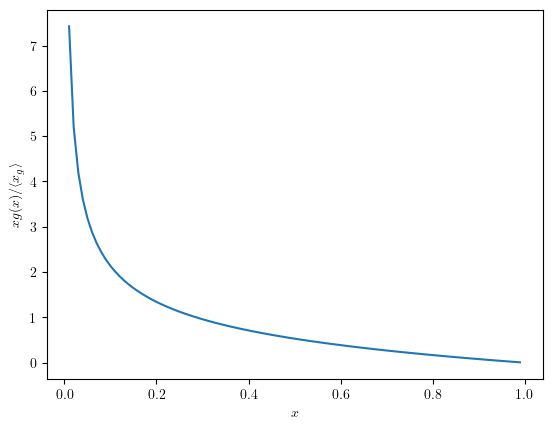

In [ ]:
#Plot of the output PDF data
plt.plot(xs_out, xgx)
plt.xlabel(r'$x$')
plt.ylabel(r'$xg(x)/\langle x_g \rangle$')

Below, we plot the psuedo-data that came from the above PDF.
We plot as a function of $\nu$ and have different lines for different values of $z$.

Text(0, 0.5, '$M(\\nu, z)$')

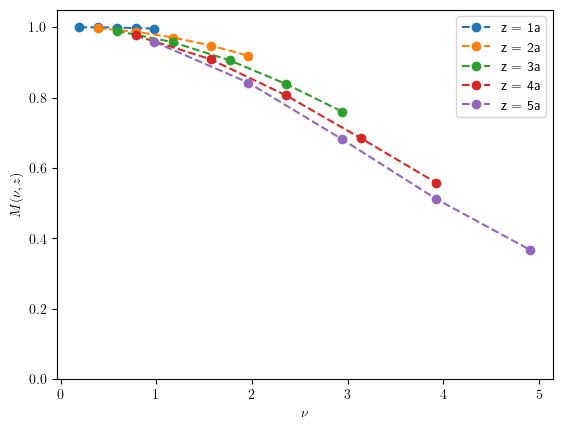

In [ ]:
#Plot of the input data

for i in range(len(zs)):
    plt.plot(nus[i], RpITD[i], 'o--', label = "z = {}a".format(int(np.round(zs[i]))))

plt.ylim(0, 1.05)

plt.legend()
plt.xlabel(r'$\nu$')
plt.ylabel(r'$M(\nu, z)$')

### Explore the ranges of $a$ and $b$ (Task 4)
Choose some different values for $a$ and $b$ and comment on any observations you have.

### Conclusion
Hopefully you have a reasonable feeling for what the input and output data look like.
For the in-class assignment, I will provide the training data, which will be 1000 copies of the same type of data that you have generated here.
The only difference is that the arrays will be flattened, to skip an extra step in the pipeline.

---
## Assignment Wrap-up

Please fill out the following Google Form when you complete this assignment

In [ ]:
from IPython.display import HTML
HTML(
"""
<iframe
	src="https://forms.gle/Y66wJvJptRiXwD4E9"
	width="80%"
	height="1200px"
	frameborder="0"
	marginheight="0"
	marginwidth="0">
	Loading...
</iframe>
"""
)